In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
import gym
from gym import spaces
import numpy as np

In [3]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from collections import deque

In [4]:
# Load the dataset
df = pd.read_csv('monthly-beer-production-in-austr.csv')

In [58]:
df

,Month,Monthly beer production
0,1956-01-01,93.2
1,1956-02-01,96.0
2,1956-03-01,95.2
3,1956-04-01,77.1
4,1956-05-01,70.9
...,...,...
471,1995-04-01,127.0
472,1995-05-01,151.0
473,1995-06-01,130.0
474,1995-07-01,119.0


In [5]:
df['Month'] = pd.to_datetime(df['Month'])
production = df['Monthly beer production'].values.reshape(-1, 1)

In [39]:
production.shape

(476, 1)

In [49]:
production

array([[ 93.2],
       [ 96. ],
       [ 95.2],
       [ 77.1],
       [ 70.9],
       [ 64.8],
       [ 70.1],
       [ 77.3],
       [ 79.5],
       [100.6],
       [100.7],
       [107.1],
       [ 95.9],
       [ 82.8],
       [ 83.3],
       [ 80. ],
       [ 80.4],
       [ 67.5],
       [ 75.7],
       [ 71.1],
       [ 89.3],
       [101.1],
       [105.2],
       [114.1],
       [ 96.3],
       [ 84.4],
       [ 91.2],
       [ 81.9],
       [ 80.5],
       [ 70.4],
       [ 74.8],
       [ 75.9],
       [ 86.3],
       [ 98.7],
       [100.9],
       [113.8],
       [ 89.8],
       [ 84.4],
       [ 87.2],
       [ 85.6],
       [ 72. ],
       [ 69.2],
       [ 77.5],
       [ 78.1],
       [ 94.3],
       [ 97.7],
       [100.2],
       [116.4],
       [ 97.1],
       [ 93. ],
       [ 96. ],
       [ 80.5],
       [ 76.1],
       [ 69.9],
       [ 73.6],
       [ 92.6],
       [ 94.2],
       [ 93.5],
       [108.5],
       [109.4],
       [105.1],
       [ 92.5],
       [

In [41]:
production_scaled

array([[0.18562092],
       [0.20392157],
       [0.19869281],
       [0.08039216],
       [0.03986928],
       [0.        ],
       [0.03464052],
       [0.08169935],
       [0.09607843],
       [0.23398693],
       [0.23464052],
       [0.27647059],
       [0.20326797],
       [0.11764706],
       [0.12091503],
       [0.09934641],
       [0.10196078],
       [0.01764706],
       [0.07124183],
       [0.04117647],
       [0.16013072],
       [0.2372549 ],
       [0.26405229],
       [0.32222222],
       [0.20588235],
       [0.12810458],
       [0.17254902],
       [0.11176471],
       [0.10261438],
       [0.03660131],
       [0.06535948],
       [0.07254902],
       [0.14052288],
       [0.22156863],
       [0.23594771],
       [0.32026144],
       [0.16339869],
       [0.12810458],
       [0.14640523],
       [0.13594771],
       [0.04705882],
       [0.02875817],
       [0.08300654],
       [0.0869281 ],
       [0.19281046],
       [0.21503268],
       [0.23137255],
       [0.337

In [6]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
production_scaled = scaler.fit_transform(production)

In [38]:
production_scaled

array([[0.18562092],
       [0.20392157],
       [0.19869281],
       [0.08039216],
       [0.03986928],
       [0.        ],
       [0.03464052],
       [0.08169935],
       [0.09607843],
       [0.23398693],
       [0.23464052],
       [0.27647059],
       [0.20326797],
       [0.11764706],
       [0.12091503],
       [0.09934641],
       [0.10196078],
       [0.01764706],
       [0.07124183],
       [0.04117647],
       [0.16013072],
       [0.2372549 ],
       [0.26405229],
       [0.32222222],
       [0.20588235],
       [0.12810458],
       [0.17254902],
       [0.11176471],
       [0.10261438],
       [0.03660131],
       [0.06535948],
       [0.07254902],
       [0.14052288],
       [0.22156863],
       [0.23594771],
       [0.32026144],
       [0.16339869],
       [0.12810458],
       [0.14640523],
       [0.13594771],
       [0.04705882],
       [0.02875817],
       [0.08300654],
       [0.0869281 ],
       [0.19281046],
       [0.21503268],
       [0.23137255],
       [0.337

In [7]:
# Assuming `production_scaled` is  normalized dataset
total_samples = len(production_scaled)
test_size = 24  # using last 12 months as the test set
sequence_length = 12
 # Include sequence_length to build the first sequence

In [8]:
# Split the data into training and test sets
train_data = production_scaled[:total_samples - test_size]
test_data = production_scaled[total_samples - test_size :] 

In [9]:
len(train_data),len(test_data)

(452, 24)

In [10]:
# Unforeseen sequence: the last `sequence_length` months from the original dataset
unforeseen_sequence = production_scaled[-sequence_length:].reshape(1, sequence_length, 1)  # Reshape for the model


In [11]:
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 12  # Use 12 months of data to predict the next month

# Create training and test sequences
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)


In [12]:
import torch
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from gym import spaces

class CustomLSTMFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 64):
        super(CustomLSTMFeaturesExtractor, self).__init__(observation_space, features_dim=features_dim)
        
        self.lstm = nn.LSTM(input_size=observation_space.shape[0], 
                            hidden_size=features_dim, 
                            batch_first=True)

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # Assuming observations are of shape [batch_size, sequence_length, features]
        lstm_out, _ = self.lstm(observations)
        # Using the last output as feature representation
        return lstm_out[:, -1, :]

class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(self, observation_space: spaces.Box, action_space: spaces.Space, 
                 lr_schedule, **kwargs):
        super(CustomActorCriticPolicy, self).__init__(observation_space, action_space, lr_schedule, 
                                                      features_extractor_class=CustomLSTMFeaturesExtractor, 
                                                      **kwargs)

        # Define actor (policy) and critic (value function) networks using features_dim from the extractor
        self.action_net = nn.Linear(self.features_extractor.features_dim, action_space.shape[0])
        self.value_net = nn.Linear(self.features_extractor.features_dim, 1)

    def _forward(self, obs: torch.Tensor, deterministic: bool = False) -> torch.Tensor:
        features = self.extract_features(obs)
        # Separate outputs for policy and value function
        return self.action_net(features), self.value_net(features)

    def extract_features(self, obs: torch.Tensor) -> torch.Tensor:
        # Directly utilize the forward method of features extractor
        return self.features_extractor(obs)




In [13]:
class ForecastingEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['console']}
    
    def __init__(self, X, y):
        super(ForecastingEnv, self).__init__()
        
        self.X = X
        self.y = y

        self.reward_factor = 1
        self.current_idx = 0
        
        # Define action and observation space
        # They must be gym.spaces objects
        # Assuming  actions are the predicted values, which could range from the min to max observed values
        # Adjust these min and max values based on  actual scaled data range
        self.action_space = spaces.Box(low=np.min(y), high=np.max(y), shape=(1,), dtype=np.float32)
        
        # Observation space represents the input sequence
        # Adjust the shape based on the shape of  input sequences
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=X[0].shape, dtype=np.float32)
        
        self.state = None
        self.done = False

    def reset(self):
        self.current_idx = 0
        self.state = self.X[self.current_idx]
        self.done = False
        return self.state

    def reward_rmse(self,predicted, actual):
        mse = np.mean((predicted - actual) ** 2)
        rmse = np.sqrt(mse)
        reward = -rmse
        return reward

    def step(self, action):
        # Execute one time step within the environment

        print('action is ',action)
        actual_next_value = self.y[self.current_idx]

        print('actual_next_value' ,actual_next_value)
        reward =  self.reward_rmse(action[0] , actual_next_value[0])
        
        print('reward is ',reward)
        
        self.current_idx += 1
        if self.current_idx >= len(self.X):
            self.done = True
            next_state = None
        else:
            next_state = self.X[self.current_idx]
            self.state = next_state
        
        return np.array(next_state, dtype=np.float32), reward, self.done, {}

    def render(self, mode='console'):
        if mode == 'console':
            if self.state is not None:
                print(f"Current State: {self.state}")

    def seed(self, seed=None):
        np.random.seed(seed)

    def close(self):
        pass


In [14]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

In [15]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

def make_forecasting_env(X, y, num_env):
    """
    Utility function for creating the vectorized environment.

    :param X: The input sequences.
    :param y: The target values.
    :param num_env: Number of parallel environments to create.
    :return: A vectorized Gym environment.
    """
    def _init():
        return ForecastingEnv(X, y)
    # Note: Removed the `env_id` parameter from the call
    return make_vec_env(_init, n_envs=num_env)



In [16]:
vec_env = make_forecasting_env(X_train, y_train, 1) 

C:\softwares\python-3.11.4\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
# Now, you can use `vec_env` with Stable Baselines 3 models
model = PPO(CustomActorCriticPolicy, vec_env,  learning_rate=1e-4,verbose=1)
model.learn(total_timesteps=5e4)
model.save('ppo_timeseries')

Using cpu device
action is  [0.01764706]
actual_next_value [0.20326797]
reward is  -0.18562091422188137
action is  [0.46707785]
actual_next_value [0.11764706]
reward is  -0.3494307924719418
action is  [0.01764706]
actual_next_value [0.12091503]
reward is  -0.10326797304541063
action is  [0.01764706]
actual_next_value [0.09934641]
reward is  -0.08169934559443032
action is  [0.01764706]
actual_next_value [0.10196078]
reward is  -0.08431372467939763
action is  [0.01764706]
actual_next_value [0.01764706]
reward is  -8.107984839078597e-10
action is  [0.5995958]
actual_next_value [0.07124183]
reward is  -0.5283539550756318
action is  [0.01764706]
actual_next_value [0.04117647]
reward is  -0.02352941095390737
action is  [0.40378577]
actual_next_value [0.16013072]
reward is  -0.24365504621680262
action is  [0.01764706]
actual_next_value [0.2372549]
reward is  -0.21960784232645642
action is  [0.6552646]
actual_next_value [0.26405229]
reward is  -0.3912123284308739
action is  [0.01764706]
actual

In [ ]:
import torch
import numpy as np

def predict(model, test_sequences):
    """
    Perform predictions on test sequences.

    :param model: The trained model.
    :param test_sequences: Test sequences as a NumPy array.
    :return: Predictions as a NumPy array.
    """
    predictions = []
    for sequence in test_sequences:
        # Assuming the model expects input shape [batch_size, sequence_length, features]
        sequence = sequence.reshape(1, *sequence.shape)
        action, _ = model.predict(sequence, deterministic=True)
        predictions.append(action)
    return np.array(predictions).flatten()  # Flatten if the predictions are one-dimensional


In [29]:
# Assuming `test_sequences` is your array of test sequences
predictions = predict(model, X_test)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Convert pred and actual to numpy arrays if they aren't already
pred = np.array(predictions)
actual = np.array(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(f"RMSE: {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_test, pred)
print(f"MAE: {mae}")

RMSE: 0.10457871117651031
MAE: 0.08325456374675877


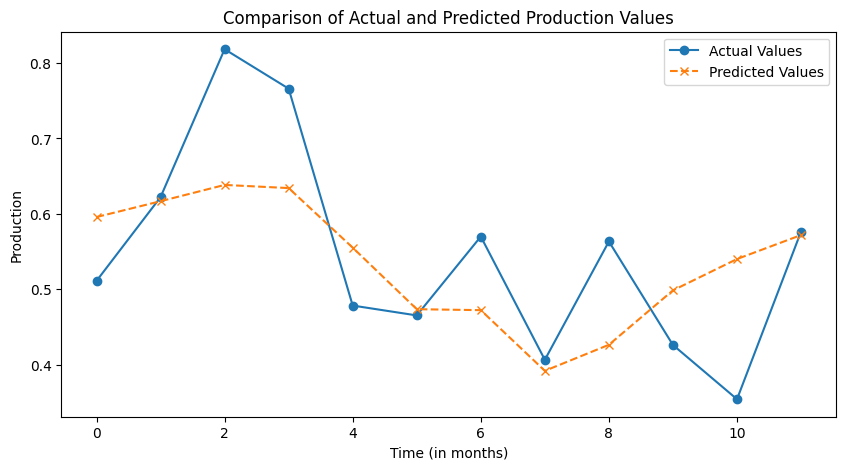

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Values', marker='o')
plt.plot(predictions, label='Predicted Values', marker='x', linestyle='--')
plt.title('Comparison of Actual and Predicted Production Values')
plt.xlabel('Time (in months)')
plt.ylabel('Production')
plt.legend()
plt.show()

In [26]:
### predictions on unforeseen data ###
unforseen_predictions_scaled = predict(model,unforeseen_sequence)

In [52]:
unforseen_pred = scaler.inverse_transform(unforseen_predictions_scaled.reshape(-1,1))

In [56]:
required_pred = unforseen_pred[0][0]

In [59]:
print('predictions for month of september 1995 is ::: ',required_pred)

predictions for month of september 1995 is :::  159.43289
